## Rede Neural MLP

In [1]:
# Importando os módulos necessários para o processamento dos dados
import numpy   as np
import pandas  as pd

# Módulos necessários para visualização dos dados
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Importando os módulos auxiliares

from sklearn.model_selection import train_test_split # Divisão de conjunto de treinamento e teste
from sklearn.model_selection import cross_validate # Validação cruzada do modelo
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV # Busca pelos melhores hiperparâmetros
from sklearn.externals import joblib # Necessário para salvar os modelos treinados em arquivos externos
from imblearn.over_sampling import SMOTE # Balanceamento de classes
from sklearn.preprocessing import LabelEncoder

# Métricas de avaliação

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import itertools

# Permite que o interpretador de latex (que aceita unicode) seja usado nos textos

matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = False

# Função auxiliar para plotar a matriz de confusão. 
# Retirada de: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')
    
def gerar_dataset_balanceado(train_data, 
                             train_target, 
                             test_data, 
                             test_target):
    
    sm = SMOTE(random_state=0, ratio='minority')
    
    encoders = list()
    
    for i in range(2): # Repete duas vezes o loop: um para o conjunto de treino e outro para o de teste
        if i == 0:
            data = train_data
            target = train_target
        elif i == 1:
            data = test_data
            target = test_target
    
        for feature in train_data.select_dtypes('object').columns:
            lb = LabelEncoder()

            lb.fit(data[feature])
            data[feature] = list(lb.transform(data[feature]))
            data[feature] = data[feature].astype('object')

            encoders.append(lb)

        data_b, target_b = sm.fit_sample(data, target)
    #     train_data_b = train_data_b.astype('int64')

    #     train_data_b = pd.DataFrame(train_data_b, columns=pd.get_dummies(train_data).columns)
        data_b = pd.DataFrame(data_b, columns=data.columns)
        data_b['earnings'] = target_b
        data_b = data_b.sample(frac=1) # Embaralha os registros

        target_b = data_b['earnings']
        data_b.drop(columns='earnings', inplace=True)

        for idx, feature in enumerate(data.select_dtypes('object').columns):

            data[feature] = encoders[idx].inverse_transform(list(data[feature]))

            data_b[feature] = data_b[feature].astype('int64')
            data_b[feature] = encoders[idx].inverse_transform(list(data_b[feature]))
        
        if i == 0:
            train_data_b = data_b
            train_target_b = target_b
        elif i == 1:
            test_data_b = data_b
            test_target_b = target_b
    
#     test_data_b, test_target_b = sm.fit_sample(pd.get_dummies(test_data), test_target)

#     test_data_b = pd.DataFrame(test_data_b, columns=pd.get_dummies(test_data).columns)
#     test_data_b['earnings'] = test_target_b
#     test_data_b = test_data_b.sample(frac=1) # Embaralha os registros
    
#     test_target_b = test_data_b['earnings']
#     test_data_b.drop(columns='earnings', inplace=True)
    
    return train_data_b, train_target_b, test_data_b, test_target_b

def exibir_resultados_finais(clf, 
                             test_data, 
                             test_target, 
                             id_abordagem, 
                             str_balanceamento, 
                             path_arquivos,
                             tipo_classificador,
                             fracao_dataset=0.1,
                             salvar_resultados=False):
    
    matplotlib.rcParams['text.usetex'] = False
    matplotlib.rcParams['text.latex.unicode'] = False
    
    # Classificando o conjunto de teste

    predicoes = clf.predict(test_data)

    if tipo_classificador == 'arvore':
    
        # Salvando a árvore treinada graficamente

        export_graphviz(clf, 
                        out_file=path_arquivos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-dataset-'+str(int(fracao_dataset*100))+'pct.dot', 
                        feature_names=test_data.columns,  
                        class_names=['Less than or equal to', 'More than'],  
                        filled=True, rounded=True,  
                        special_characters=True)  

    # Avaliando o desempenho

    # Matriz de confusão

    cfs_mtx = confusion_matrix(test_target, predicoes)
    plt.figure(figsize=(20,10))
    sns.set(font_scale=2)
    ax = sns.heatmap(cfs_mtx, 
                     xticklabels=['$\leq50$K', '$>50$K'], 
                     yticklabels=['$\leq50$K', '$>50$K'], 
                     annot=cfs_mtx,
                     fmt='d',
                     cbar=None)

    ax.set_xlabel('Predito', labelpad=20, fontsize=30)
    ax.set_ylabel('Real', labelpad=20, fontsize=30)
    ax.set_title('Matriz de Confusão')
    
    acc = accuracy_score(test_target, predicoes)
    pre = precision_score(test_target, predicoes)
    rec = recall_score(test_target, predicoes)
    f1 = f1_score(test_target, predicoes)
    
    if tipo_classificador in ['svm-rbf','svm-linear']:
        predicoes = clf.decision_function(test_data)
    elif tipo_classificador in ['arvore','naive-bayes','logit','knn','rf']:
        predicoes = clf.predict_proba(test_data)[:,1]
    
    roc_auc = roc_auc_score(test_target, predicoes)
    prc_auc = average_precision_score(test_target, predicoes)

    print('Acurácia: %.3f %%' % (acc*100))
    print('Precisão: %.3f %%' % (pre*100))
    print('Recall: %.3f %%' % (rec*100))
    print('F1 score: %3f %%' % (f1*100))
    print('ROC AUC: %.3f %%' % (roc_auc*100))
    print('PRC AUC: %.3f %%' % (prc_auc*100))

    # plot_confusion_matrix(cfs_mtx, ['<=50K', '>50K'], normalize=False)
    
    if salvar_resultados:
        if tipo_classificador == 'arvore':
            path_graficos = 'Classificadores/Arvores-decisao/'
        elif tipo_classificador in ['svm-linear', 'svm-rbf']:
            path_graficos = 'Classificadores/SVM/'
        elif tipo_classificador == 'naive-bayes':
            path_graficos = 'Classificadores/Naive-bayes/'
        elif tipo_classificador == 'logit':
            path_graficos = 'Classificadores/Regressao-logistica/'
            
        joblib.dump(predicoes,
                    path_arquivos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-predicoes.pkl')    
        
        filename = path_graficos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-matriz-confusao.png'
        plt.savefig(filename)
        
        d = {'Acuracia': acc, 
             'Precisao': pre, 
             'Recall': rec, 
             'F1': f1,
             'ROC AUC': roc_auc, 
             'PRC AUC': prc_auc}
        
        temp = pd.Series(data=d).to_csv(path=path_arquivos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-medidas.csv', sep=',')
        
        
    plt.show()
    
    matplotlib.rcParams['text.usetex'] = False
    matplotlib.rcParams['text.latex.unicode'] = False

def gerarLinhaTabelaResultadosCVRedeNeural(metricas, 
                                           n_splits,
                                           train_scores_acc, 
                                           train_scores_pre,
                                           train_scores_rec,
                                           train_scores_f1,
                                           train_scores_roc,
                                           val_scores_acc,
                                           val_scores_pre,
                                           val_scores_rec,
                                           val_scores_f1,
                                           val_scores_roc):
    
    ''' Essa função cria uma linha contendo os resultados da validação cruzada de uma determinada configuração
        de rede neural para cada métrica passada. No momento, as métricas aceitas são acurácia, precisão, recall
        f1 score e roc auc. Todas elas devem ser passadas na lista metricas. Ao término da função, os valores
        da linha da tabela são retornados, permitindo que tal linha seja adicionada a uma tabela externa. '''

    # Tabela com resultados de treino

    tb_train = pd.DataFrame(columns=['split'+str(i)+'_train_'+metrica for i in list(range(0,n_splits)) for metrica in metricas])

    idx_vetores = -1
    for idx2,col in enumerate(tb_train.columns):
        if idx2%5 == 0:
            idx_vetores += 1
            vetor = train_scores_acc
        elif idx2%5 == 1:
            vetor = train_scores_pre
        elif idx2%5 == 2:
            vetor = train_scores_rec
        elif idx2%5 == 3:
            vetor = train_scores_f1
        elif idx2%5 == 4:
            vetor = train_scores_roc

        tb_train.loc[0,col] = vetor[idx_vetores]

    # Tabela com resultados de validação

    tb_val = pd.DataFrame(columns=['split'+str(i)+'_test_'+metrica for i in list(range(0,n_splits)) for metrica in metricas])

    idx_vetores = -1
    for idx2,col in enumerate(tb_val.columns):
        if idx2%5 == 0:
            idx_vetores += 1
            vetor = val_scores_acc
        elif idx2%5 == 1:
            vetor = val_scores_pre
        elif idx2%5 == 2:
            vetor = val_scores_rec
        elif idx2%5 == 3:
            vetor = val_scores_f1
        elif idx2%5 == 4:
            vetor = val_scores_roc

        tb_val.loc[0,col] = vetor[idx_vetores]

    # Concatenação das duas tabelas

    tb = pd.concat([tb_train, tb_val], axis=1)
    
    return tb.values # Retorna somente os valores das linhas, e não a tabela criada.


# ATENÇÃO!!! Escolher corretamente qual a fração do dataset que está sendo utilizada

fracao_dataset = 0.1

In [2]:
# Importando os arquivos com os datasets pré-processados

path_arquivos = 'Data/'

data_pre_proc_1 = pd.read_csv(path_arquivos+'data-pre-proc-1.csv')
data_pre_proc_2 = pd.read_csv(path_arquivos+'data-pre-proc-2.csv')
data_pre_proc_3 = pd.read_csv(path_arquivos+'data-pre-proc-3.csv')
data_pre_proc_4 = pd.read_csv(path_arquivos+'data-pre-proc-4.csv')

# Descartando a primeira coluna, que é só identificador do registro

data_pre_proc_1 = data_pre_proc_1.iloc[:,1::]
data_pre_proc_2 = data_pre_proc_2.iloc[:,1::]
data_pre_proc_3 = data_pre_proc_3.iloc[:,1::]
data_pre_proc_4 = data_pre_proc_4.iloc[:,1::]

# Separando o target e dividindo os conjuntos de treino e teste para cada dataset

# Dataset 1

target_1 = data_pre_proc_1['earnings']
data_pre_proc_1.drop(columns='earnings', inplace=True)

train_data_1, test_data_1, train_target_1, test_target_1 = train_test_split(
    data_pre_proc_1, target_1, test_size=0.33, random_state=0)

train_data_b_1, train_target_b_1, test_data_b_1, test_target_b_1 = gerar_dataset_balanceado(
    train_data_1, train_target_1, test_data_1, test_target_1)

# Dataset 2

target_2 = data_pre_proc_2['earnings']
data_pre_proc_2.drop(columns='earnings', inplace=True)

train_data_2, test_data_2, train_target_2, test_target_2 = train_test_split(
    data_pre_proc_2, target_2, test_size=0.33, random_state=0)

train_data_b_2, train_target_b_2, test_data_b_2, test_target_b_2 = gerar_dataset_balanceado(
    train_data_2, train_target_2, test_data_2, test_target_2)
    
# Dataset 3
    
target_3 = data_pre_proc_3['earnings']
data_pre_proc_3.drop(columns='earnings', inplace=True)

train_data_3, test_data_3, train_target_3, test_target_3 = train_test_split(
    data_pre_proc_3, target_3, test_size=0.33, random_state=0)

train_data_b_3, train_target_b_3, test_data_b_3, test_target_b_3 = gerar_dataset_balanceado(
    train_data_3, train_target_3, test_data_3, test_target_3)
    
# Dataset 4    

target_4 = data_pre_proc_4['earnings']
data_pre_proc_4.drop(columns='earnings', inplace=True)

train_data_4, test_data_4, train_target_4, test_target_4 = train_test_split(
    data_pre_proc_4, target_4, test_size=0.33, random_state=0)

train_data_b_4, train_target_b_4, test_data_b_4, test_target_b_4 = gerar_dataset_balanceado(
    train_data_4, train_target_4, test_data_4, test_target_4)

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future th

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.

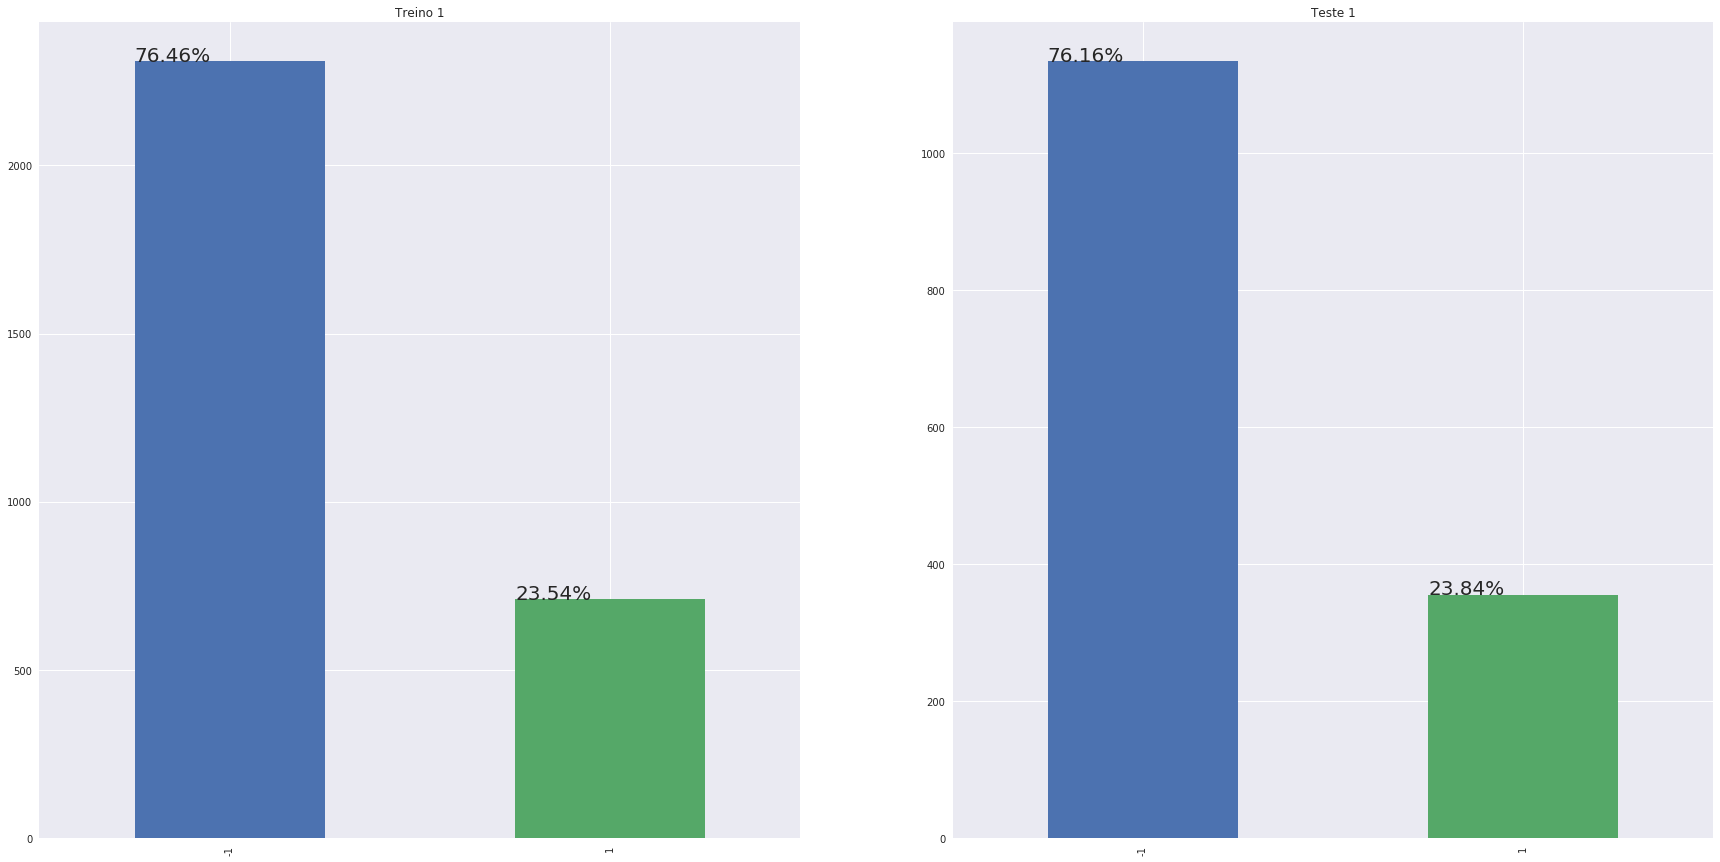

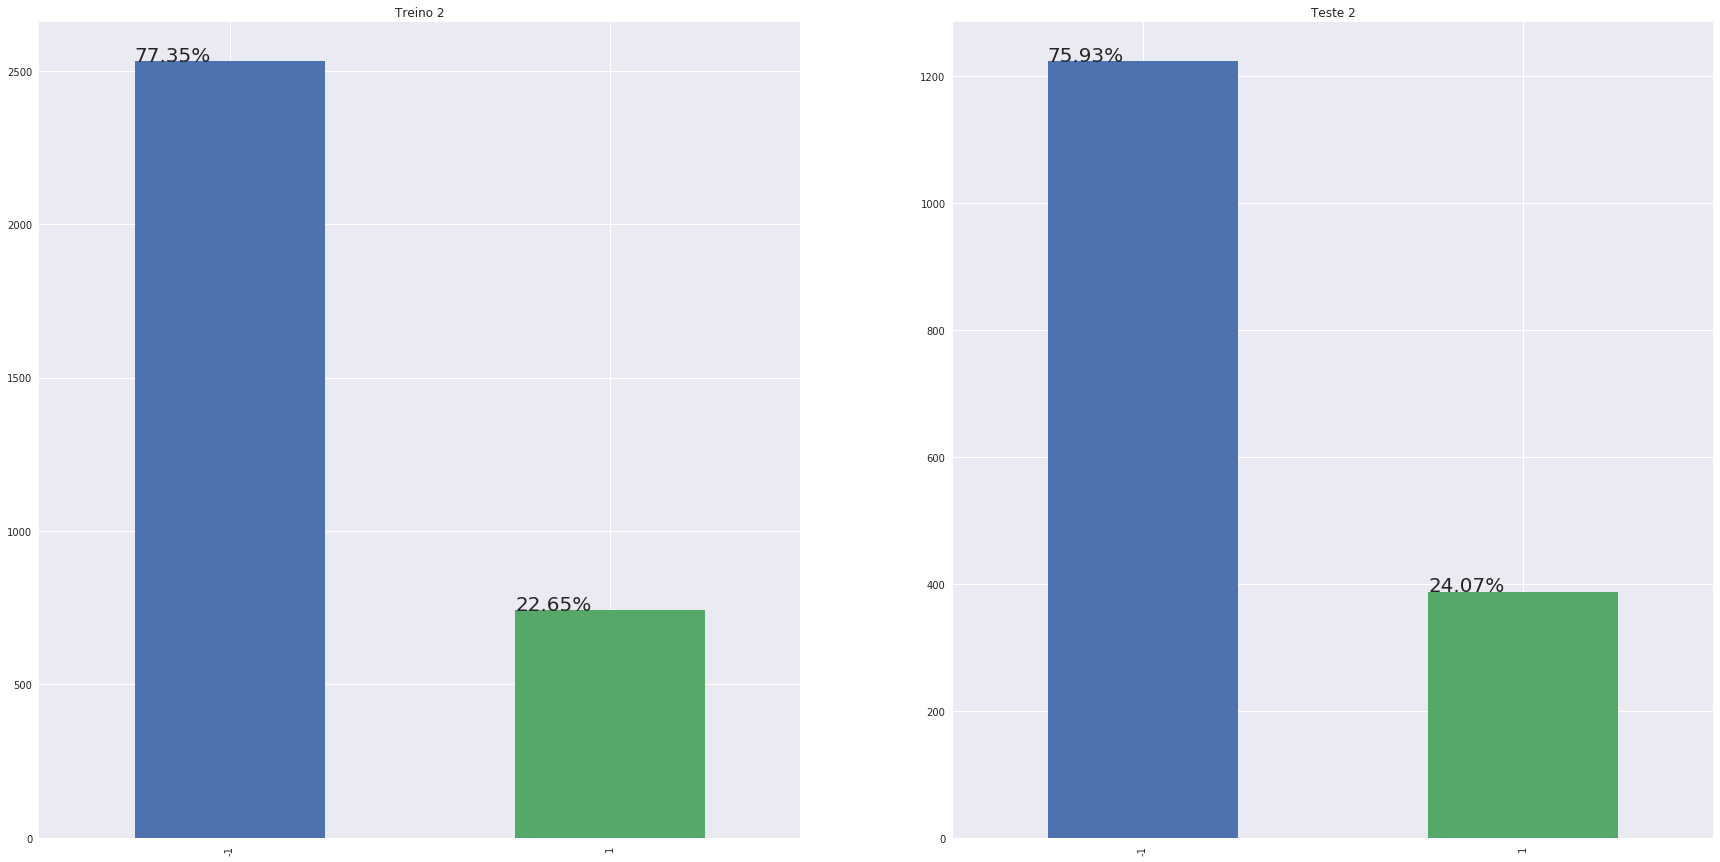

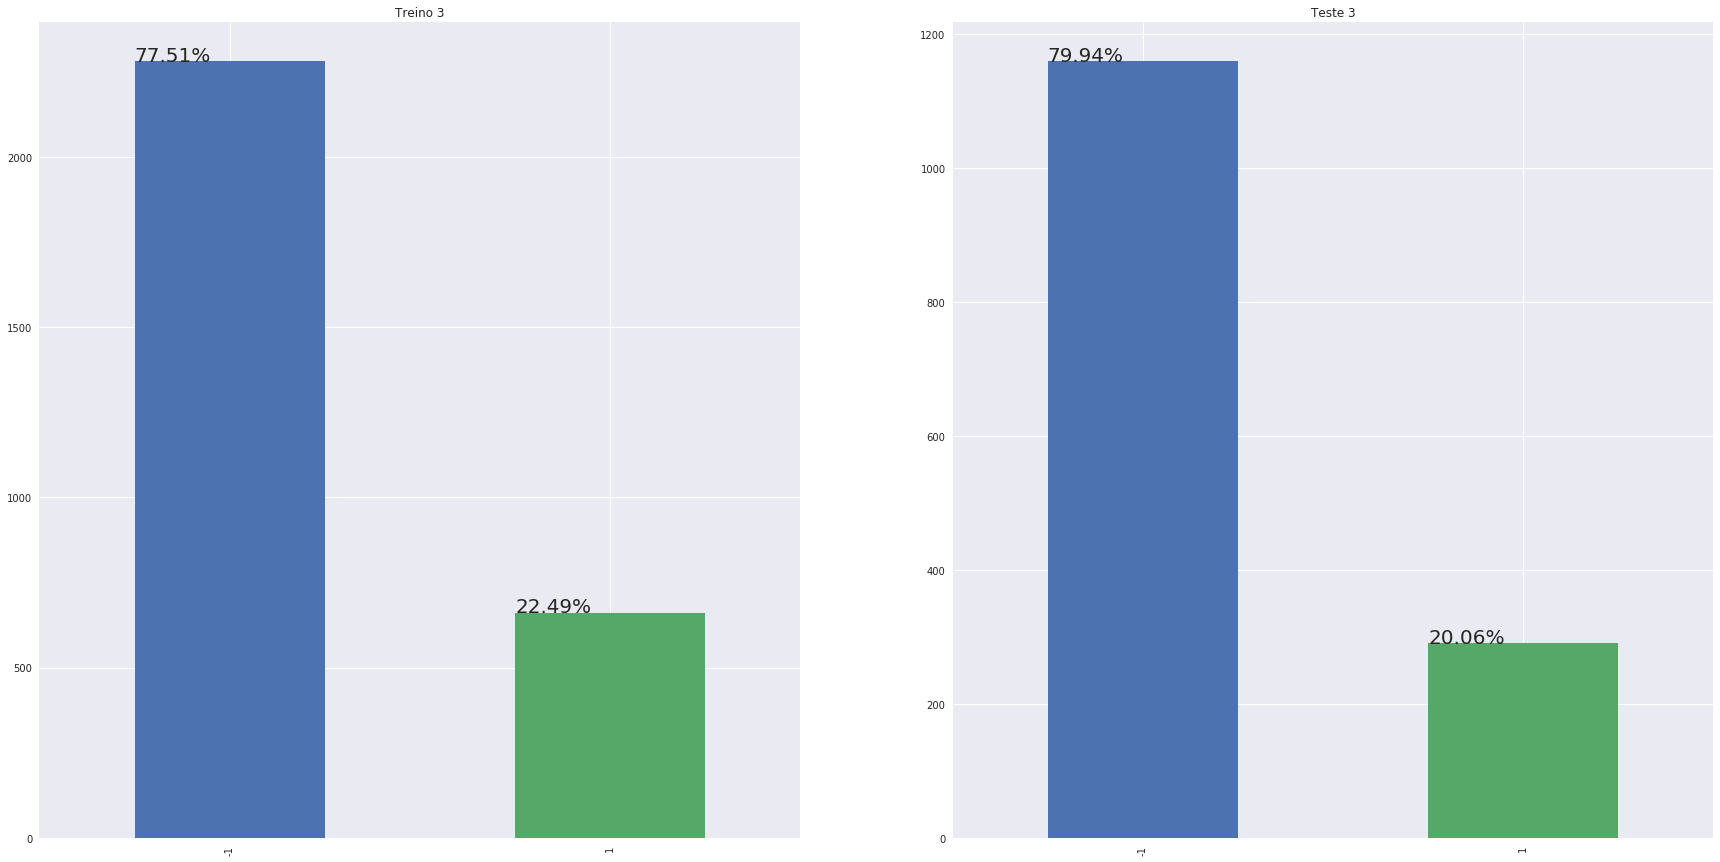

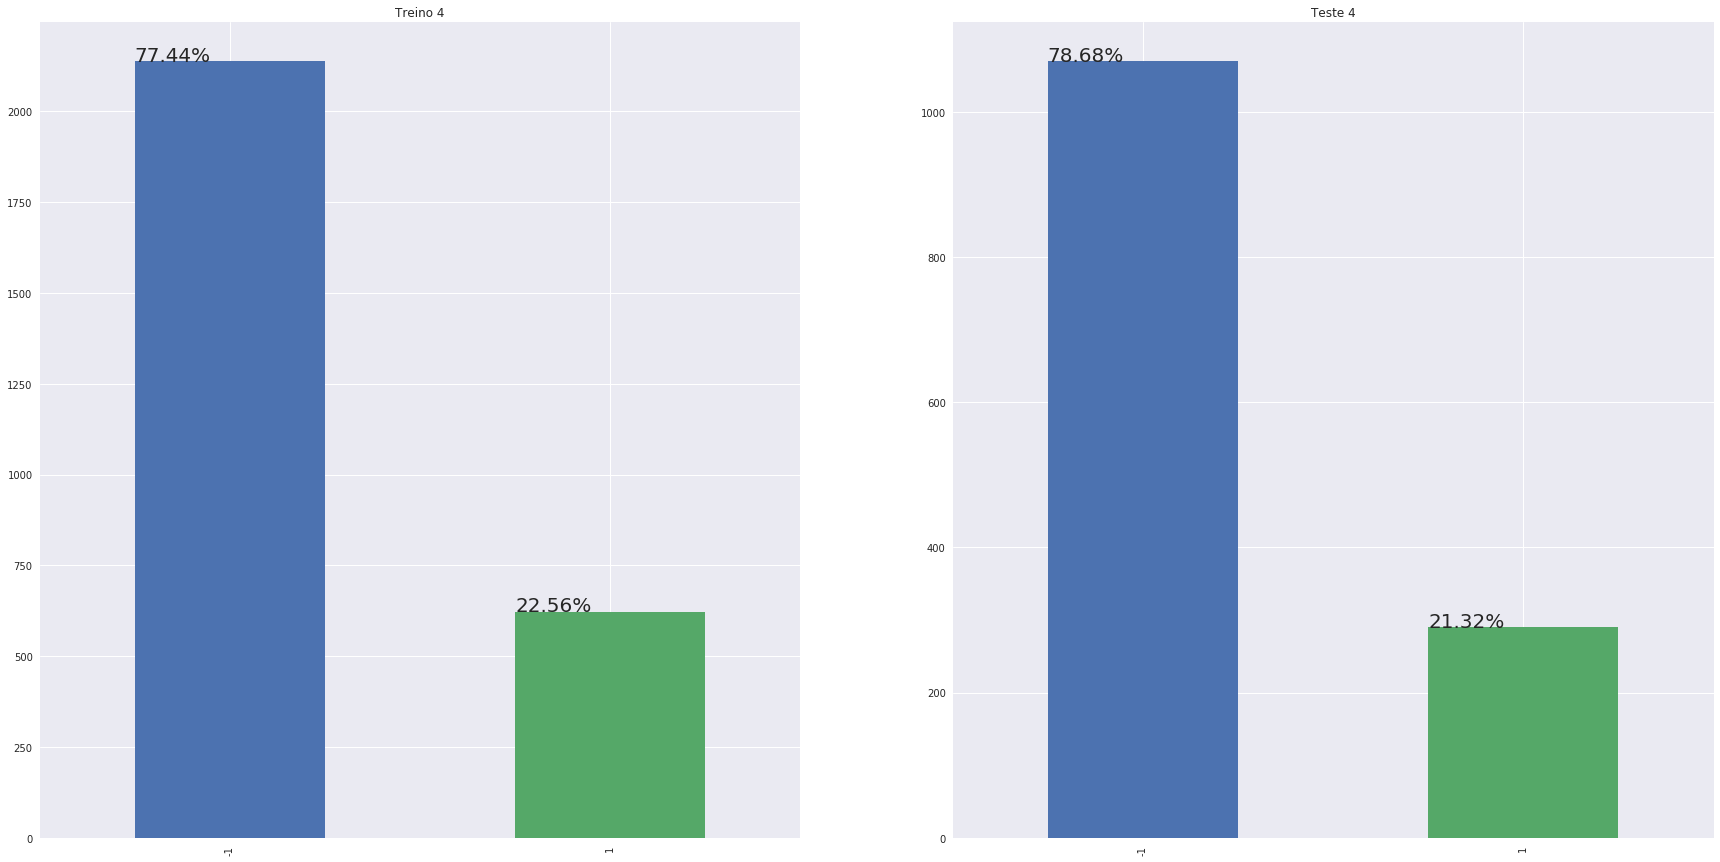

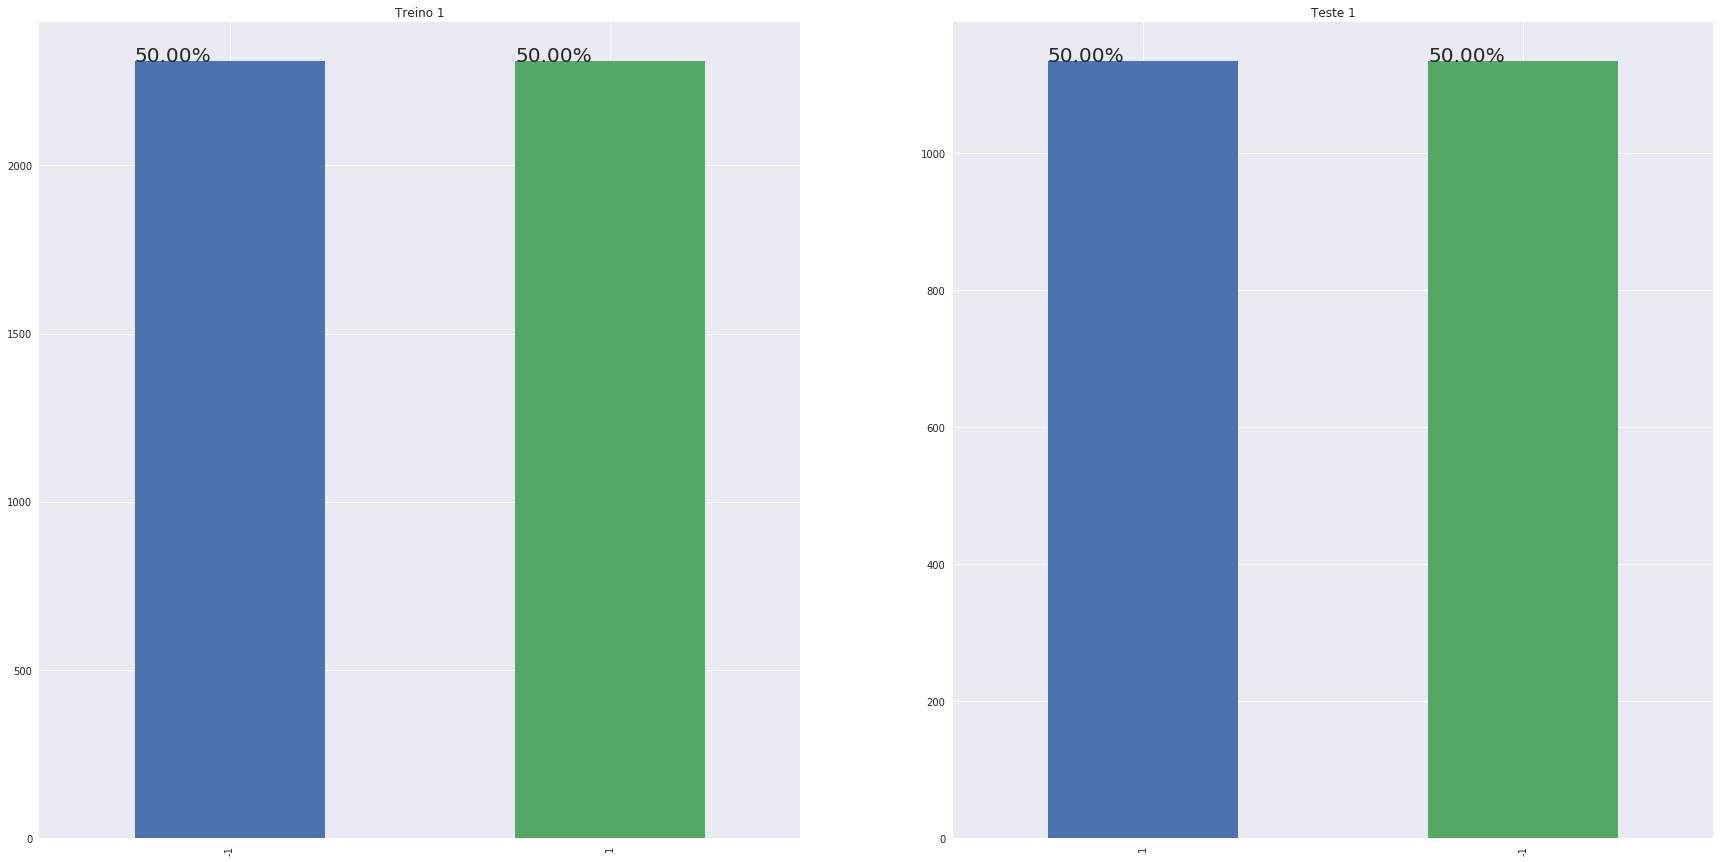

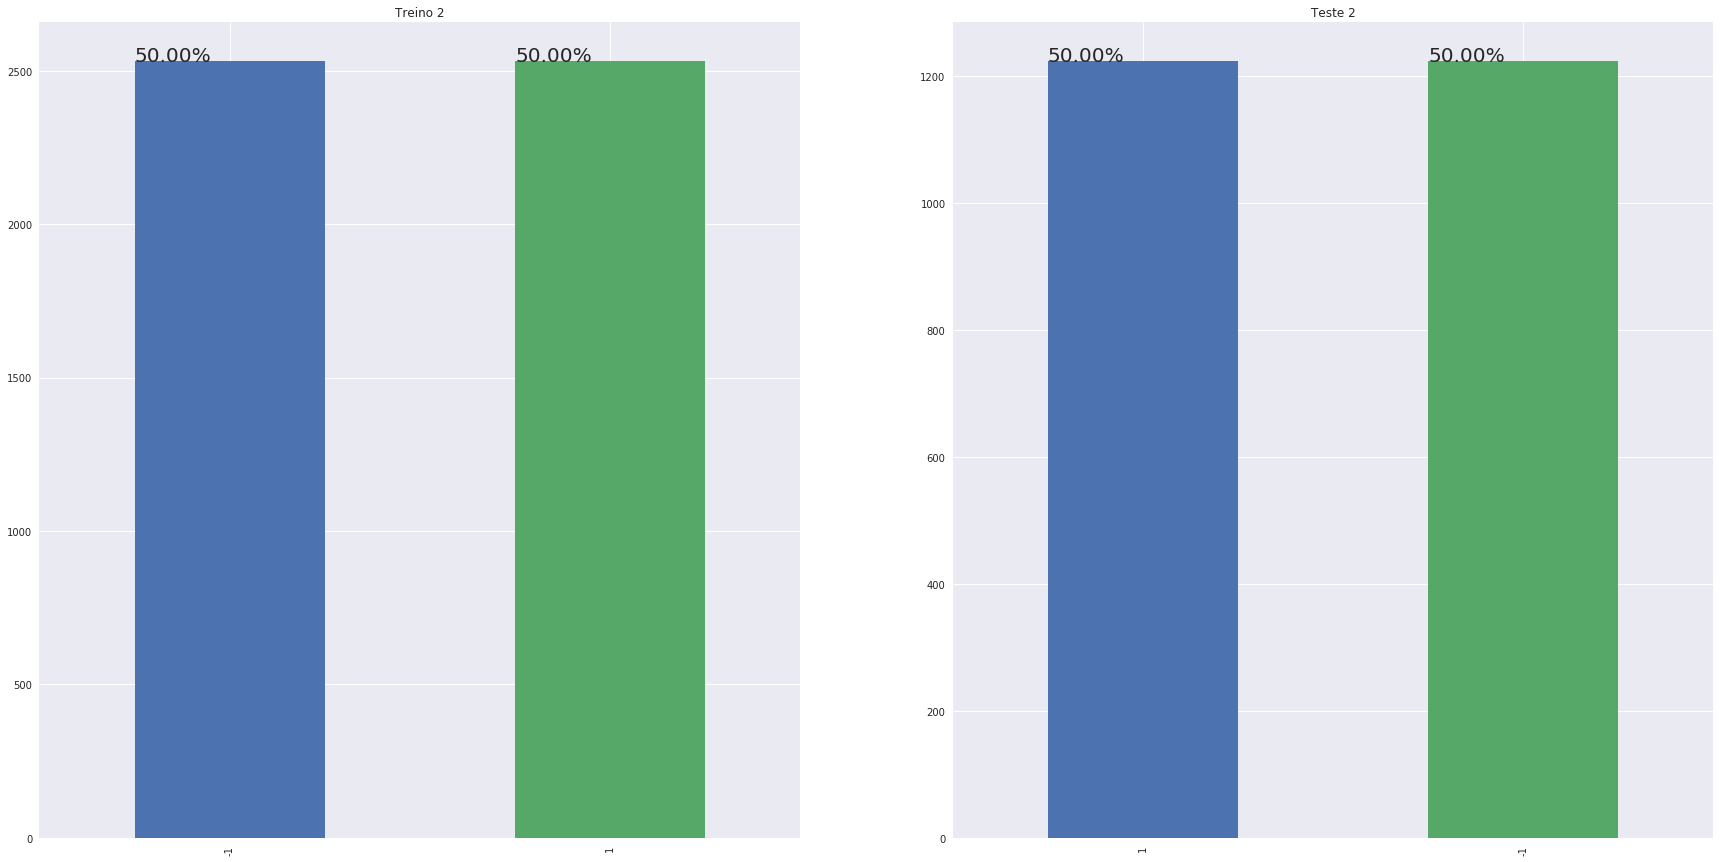

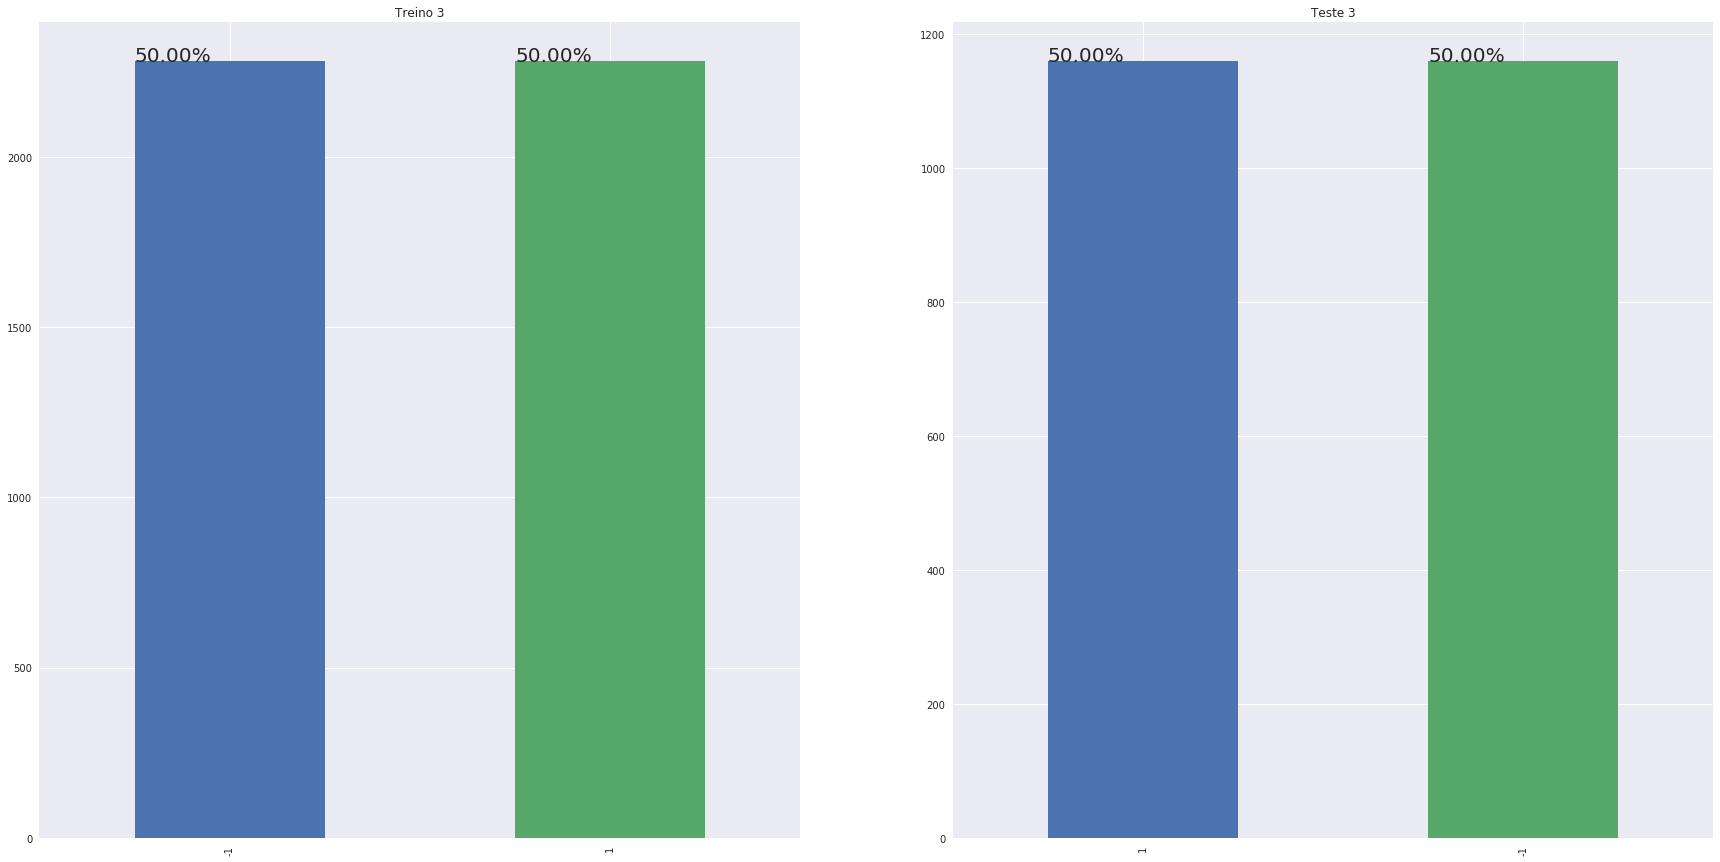

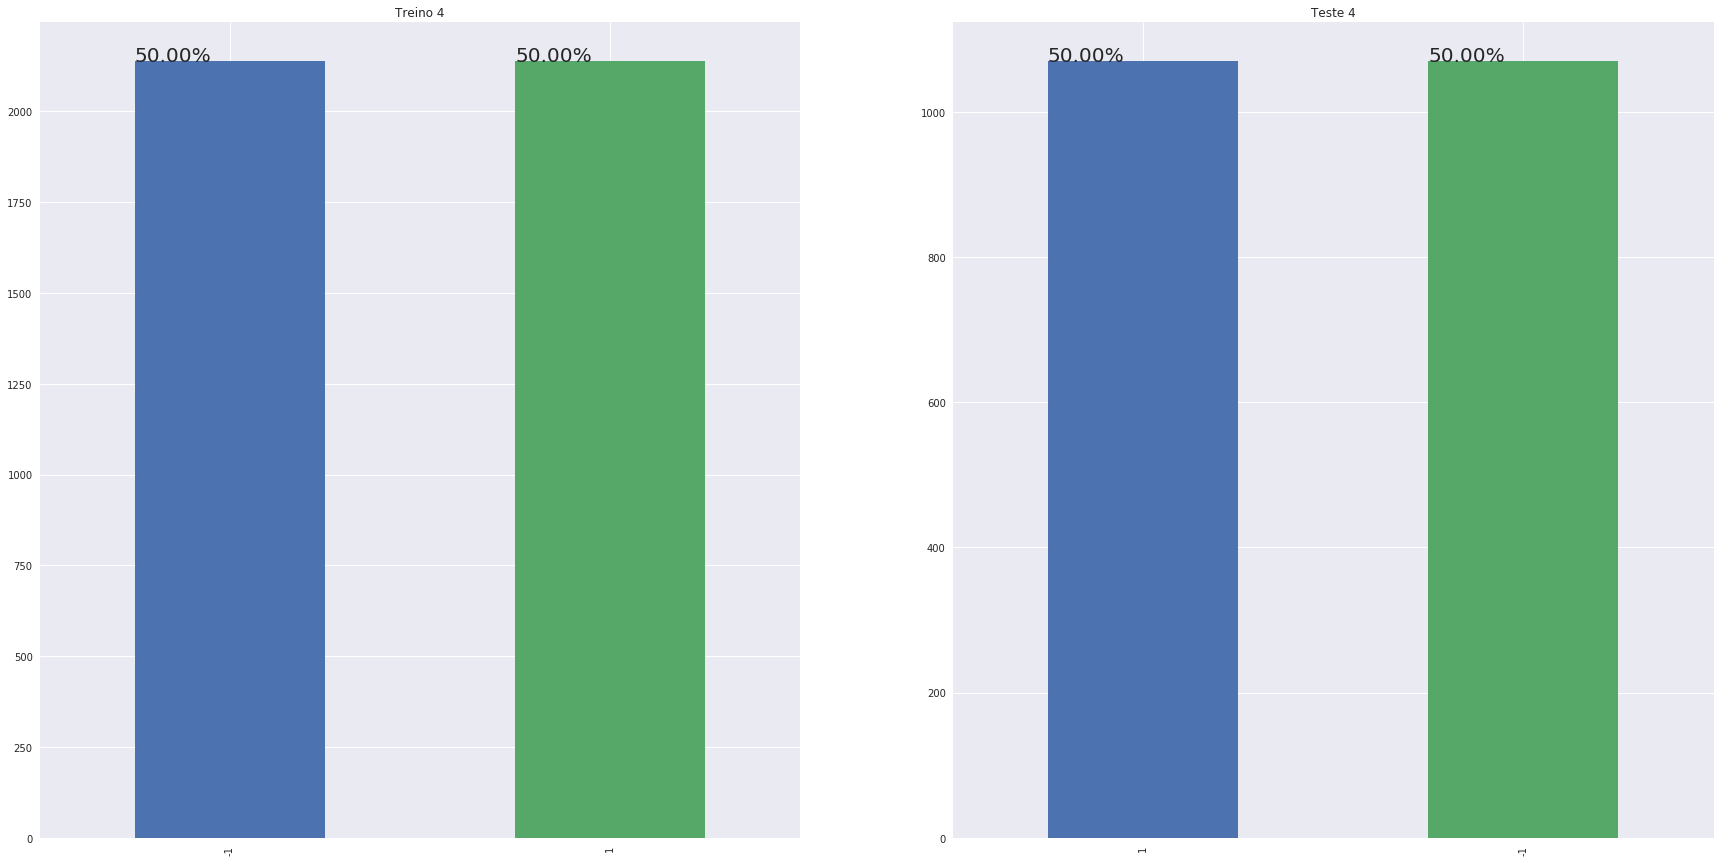

In [3]:
# Checando a distribuição dos targets em cada conjunto (treino e teste) de cada abordagem

sns.set(style='darkgrid')
temp_train = [train_target_1, train_target_2, train_target_3, train_target_4]
temp_test = [test_target_1, test_target_2, test_target_3, test_target_4]

for i in range(4):
    
    fig = plt.figure(figsize=(30,15))

    plt.subplot(121)
    ax = temp_train[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_train[i].shape[0]*100)),fontsize=20)
    plt.title('Treino ' + str(i+1))
#     plt.show()

#     fig = plt.figure(figsize=(30,15))
    
    plt.subplot(122)
    ax = temp_test[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_test[i].shape[0]*100)),fontsize=20)
    plt.title('Teste ' + str(i+1))
#     plt.show()

temp_train_b = [train_target_b_1, train_target_b_2, train_target_b_3, train_target_b_4]
temp_test_b = [test_target_b_1, test_target_b_2, test_target_b_3, test_target_b_4]

for i in range(4):
    
    fig = plt.figure(figsize=(30,15))

    plt.subplot(121)
    ax = temp_train_b[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_train_b[i].shape[0]*100)),fontsize=20)
    plt.title('Treino ' + str(i+1))
#     plt.show()

#     fig = plt.figure(figsize=(30,15))
    
    plt.subplot(122)
    ax = temp_test_b[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_test_b[i].shape[0]*100)),fontsize=20)
    plt.title('Teste ' + str(i+1))
#     plt.show()

#### Treinamento

In [14]:
# Importando o keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import TensorBoard
from time import time
from sklearn.model_selection import StratifiedKFold

n_splits_kfold = 10

path_arquivos = 'Classificadores/Redes-neurais-MLP-2/'

metricas = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

datasets_treino = [train_data_2, train_data_b_2, train_data_1, train_data_b_1, train_data_3, train_data_b_3, train_data_4, train_data_b_4]
targets_treino = [train_target_2, train_target_b_2, train_target_1, train_target_b_1, train_target_3, train_target_b_3, train_target_4, train_target_b_4]

# datasets_treino = [train_data_2, train_data_b_2]
# targets_treino = [train_target_2, train_target_b_2]

# Dicionário para saber a qual abordagem a iteração atual corresponde. Lembrando que, como existem
# duas versões de dataset (balanceado e desbalanceado) para cada abordagem, e, ao todo, são 4 
# abordagens, segue que a cada 2 iterações, a abordagem muda. Como começa pela abordagem 2 (em vez da 1), 
# as duas primeiras iterações referem-se à abordagem 2.

abordagens_dict = {0: 2, 1: 2,
                   2: 1, 3: 1,
                   4: 3, 5: 3,
                   6: 4, 7: 4}

for aux, (train, target) in enumerate(zip(datasets_treino, targets_treino)):
    
    # Criação da tabela que armazenará os resultados da validação cruzada. Essa tabela, por enquanto, 
    # só contém o cabeçalho. Após uma rodada da validação cruzada, uma linha é adicionada a essa tabela,
    # contendo as estatísticas de cada fold de treino e validação. Novas linhas são adicionadas conforme,
    # novas configurações de rede vão sendo treinadas na validação cruzada. Cada nova configuração, no caso,
    # corresponde a uma rede com um determinado número de neurônios na camada escondida.
    
    tb_train = pd.DataFrame(columns=['split'+str(i)+'_train_'+metrica for i in list(range(0,n_splits_kfold)) for metrica in metricas])
    tb_val = pd.DataFrame(columns=['split'+str(i)+'_test_'+metrica for i in list(range(0,n_splits_kfold)) for metrica in metricas])
    tb = pd.concat([tb_train, tb_val], axis=1)
    
    id_abordagem = abordagens_dict[aux]
    
    if aux % 2 == 0:
        str_balanceamento = 'desbalanceado'
    else:
        str_balanceamento = 'balanceado'
    
    train_ann = pd.get_dummies(train).values
    target_ann = target.replace(-1,0).values

#     Criação de uma rede

    param_range = list(map(int,np.logspace(start=1,stop=12,num=12,base=2))) # Número de neurônios na camada escondida
    
    idx_linha = 0 # Index da nova linha da tabela

    for n_neuronios in param_range:

        model = Sequential()
        model.add(Dense(n_neuronios, input_shape=(train_ann.shape[1],), activation='sigmoid'))
        # model.add(Dense(100, activation='sigmoid'))
        model.add(Dense(1, activation='sigmoid'))

        # Problema de classificação binária,
        model.compile(optimizer='NAdam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])


        tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0,write_graph=True, write_images=True)

        # Validação cruzada

        kfold = StratifiedKFold(n_splits=n_splits_kfold,shuffle=True,random_state=0)

        # Criação dos vetores que armazenam os resultados das métricas
        
        train_scores_acc = np.zeros(n_splits_kfold)
        val_scores_acc = np.zeros(n_splits_kfold)
        
        train_scores_pre = np.zeros(n_splits_kfold)
        val_scores_pre = np.zeros(n_splits_kfold)
        
        train_scores_rec = np.zeros(n_splits_kfold)
        val_scores_rec = np.zeros(n_splits_kfold)

        train_scores_f1 = np.zeros(n_splits_kfold)
        val_scores_f1 = np.zeros(n_splits_kfold)

        train_scores_roc = np.zeros(n_splits_kfold)
        val_scores_roc = np.zeros(n_splits_kfold)

        # Loop da validação cruzada
        
        n_rodada = 0
        for idx_treino,idx_validacao in kfold.split(train_ann,target_ann):

            # Treinamento da rede
            model.fit(train_ann[idx_treino], target_ann[idx_treino], epochs=400, batch_size=16, callbacks=[tbCallBack], verbose=0)

            # Cálculo das probabilidades de cada classe para cada registro
            train_predictions_proba = model.predict(train_ann[idx_treino])
            val_predictions_proba = model.predict(train_ann[idx_validacao])

            # Definição das labels de cada registro, baseados nas probabilidades das classes para o registro em questão 
            train_predictions_labels = np.zeros(train_predictions_proba[:,0].shape[0])
            for i in range(0,train_predictions_proba[:,0].shape[0]):
                train_predictions_labels[i] = 1 if (train_predictions_proba[:,0][i] > 0.5) else 0

            val_predictions_labels = np.zeros(val_predictions_proba[:,0].shape[0])
            for i in range(0,val_predictions_proba[:,0].shape[0]):
                val_predictions_labels[i] = 1 if (val_predictions_proba[:,0][i] > 0.5) else 0

            # Cálculo das medidas
            train_scores_acc[n_rodada] = accuracy_score(target_ann[idx_treino],train_predictions_labels)
            val_scores_acc[n_rodada] = accuracy_score(target_ann[idx_validacao],val_predictions_labels)
            
            train_scores_pre[n_rodada] = precision_score(target_ann[idx_treino],train_predictions_labels)
            val_scores_pre[n_rodada] = precision_score(target_ann[idx_validacao],val_predictions_labels)
            
            train_scores_rec[n_rodada] = recall_score(target_ann[idx_treino],train_predictions_labels)
            val_scores_rec[n_rodada] = recall_score(target_ann[idx_validacao],val_predictions_labels)

            train_scores_f1[n_rodada] = f1_score(target_ann[idx_treino],train_predictions_labels)
            val_scores_f1[n_rodada] = f1_score(target_ann[idx_validacao],val_predictions_labels)

            train_scores_roc[n_rodada] = roc_auc_score(target_ann[idx_treino],train_predictions_proba)
            val_scores_roc[n_rodada] = roc_auc_score(target_ann[idx_validacao],val_predictions_proba)

            n_rodada = n_rodada+1

        # Adição de uma linha, contendo os resultados de validação cruzada do treino da rede, à tabela criada anteriormente 

        linha = gerarLinhaTabelaResultadosCVRedeNeural(metricas, 
                                                       n_splits_kfold,
                                                       train_scores_acc,
                                                       train_scores_pre,
                                                       train_scores_rec,
                                                       train_scores_f1,
                                                       train_scores_roc,
                                                       val_scores_acc,
                                                       val_scores_pre,
                                                       val_scores_rec,
                                                       val_scores_f1,
                                                       val_scores_roc)
#         display(linha)
        tb.loc[idx_linha,:] = linha
        idx_linha += 1
    
    tb['param_n_neuronios'] = param_range
    joblib.dump(tb, path_arquivos+'mlp-one-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada
#     display(tb)

Epoch 1/5
2943/2943 [==============================] - 0s 93us/step - loss: 0.5353 - acc: 0.7737
Epoch 2/5
2943/2943 [==============================] - 0s 64us/step - loss: 0.4712 - acc: 0.7737
Epoch 3/5
2943/2943 [==============================] - 0s 68us/step - loss: 0.4303 - acc: 0.7737
Epoch 4/5
2943/2943 [==============================] - 0s 67us/step - loss: 0.4070 - acc: 0.7737
Epoch 5/5
2943/2943 [==============================] - 0s 66us/step - loss: 0.3928 - acc: 0.7825
Epoch 1/5
2945/2945 [==============================] - 0s 64us/step - loss: 0.3814 - acc: 0.7925
Epoch 2/5
2945/2945 [==============================] - 0s 64us/step - loss: 0.3737 - acc: 0.8119
Epoch 3/5
2945/2945 [==============================] - 0s 63us/step - loss: 0.3679 - acc: 0.8285
Epoch 4/5
2945/2945 [==============================] - 0s 75us/step - loss: 0.3629 - acc: 0.8329
Epoch 5/5
2945/2945 [==============================] - 0s 73us/step - loss: 0.3592 - acc: 0.8404
Epoch 1/5
2945/2945 [=========

2945/2945 [==============================] - 0s 65us/step - loss: 0.3300 - acc: 0.8482
Epoch 1/5
2945/2945 [==============================] - 0s 63us/step - loss: 0.3294 - acc: 0.8455
Epoch 2/5
2945/2945 [==============================] - 0s 62us/step - loss: 0.3289 - acc: 0.8486
Epoch 3/5
2945/2945 [==============================] - 0s 65us/step - loss: 0.3287 - acc: 0.8448
Epoch 4/5
2945/2945 [==============================] - 0s 74us/step - loss: 0.3283 - acc: 0.8472
Epoch 5/5
2945/2945 [==============================] - 0s 69us/step - loss: 0.3280 - acc: 0.8472
Epoch 1/5
2945/2945 [==============================] - 0s 63us/step - loss: 0.3330 - acc: 0.8486
Epoch 2/5
2945/2945 [==============================] - 0s 62us/step - loss: 0.3321 - acc: 0.8472
Epoch 3/5
2945/2945 [==============================] - 0s 61us/step - loss: 0.3325 - acc: 0.8465
Epoch 4/5
2945/2945 [==============================] - 0s 62us/step - loss: 0.3319 - acc: 0.8465
Epoch 5/5
2945/2945 [===================

4556/4556 [==============================] - 0s 72us/step - loss: 0.3984 - acc: 0.8200
Epoch 5/5
4556/4556 [==============================] - 0s 68us/step - loss: 0.3974 - acc: 0.8176
Epoch 1/5
4556/4556 [==============================] - 0s 65us/step - loss: 0.3950 - acc: 0.8220
Epoch 2/5
4556/4556 [==============================] - 0s 74us/step - loss: 0.3944 - acc: 0.8211
Epoch 3/5
4556/4556 [==============================] - 0s 68us/step - loss: 0.3933 - acc: 0.8198
Epoch 4/5
4556/4556 [==============================] - 0s 69us/step - loss: 0.3930 - acc: 0.8202
Epoch 5/5
4556/4556 [==============================] - 0s 68us/step - loss: 0.3921 - acc: 0.8218
Epoch 1/5
4556/4556 [==============================] - 0s 72us/step - loss: 0.3906 - acc: 0.8209
Epoch 2/5
4556/4556 [==============================] - 0s 65us/step - loss: 0.3898 - acc: 0.8202
Epoch 3/5
4556/4556 [==============================] - 0s 62us/step - loss: 0.3894 - acc: 0.8196
Epoch 4/5
4556/4556 [===================

4554/4554 [==============================] - 0s 63us/step - loss: 0.4309 - acc: 0.8112
Epoch 4/5
4554/4554 [==============================] - 0s 63us/step - loss: 0.4202 - acc: 0.8107
Epoch 5/5
4554/4554 [==============================] - 0s 61us/step - loss: 0.4138 - acc: 0.8171
Epoch 1/5
4556/4556 [==============================] - 0s 63us/step - loss: 0.4100 - acc: 0.8176
Epoch 2/5
4556/4556 [==============================] - 0s 64us/step - loss: 0.4064 - acc: 0.8167
Epoch 3/5
4556/4556 [==============================] - 0s 62us/step - loss: 0.4038 - acc: 0.8194
Epoch 4/5
4556/4556 [==============================] - 0s 62us/step - loss: 0.4009 - acc: 0.8191
Epoch 5/5
4556/4556 [==============================] - 0s 62us/step - loss: 0.3992 - acc: 0.8194
Epoch 1/5
4556/4556 [==============================] - 0s 62us/step - loss: 0.3918 - acc: 0.8227
Epoch 2/5
4556/4556 [==============================] - 0s 67us/step - loss: 0.3890 - acc: 0.8235
Epoch 3/5
4556/4556 [===================

In [ ]:
path_arquivos = 'Classificadores/Redes-neurais-MLP-2/'
path_graficos = 'Classificadores/Redes-neurais-MLP-2/graficos/'
str_balanceamento='desbalanceado'
param = 'param_n_neuronios'

results = joblib.load(path_arquivos+'mlp-one-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')
# display(results)
results.sort_values(by=[param], axis=0, inplace=True)

results_test = results.loc[:, 'split0_train_accuracy':'split9_test_roc_auc']
display(results_test)
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()
    
    display(results_test_filtered)

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(np.arange(0,len(results_test_filtered.columns)), results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    
#     filename_graficos = 'svm-rbf-abordagem-2-'+str_balanceamento+'-erros-'+str(metrica[0])+'.png'
#     plt.savefig(path_graficos+filename_graficos)
    
    plt.show()

,split0_train_accuracy,split0_train_precision,split0_train_recall,split0_train_f1,split0_train_roc_auc,split1_train_accuracy,split1_train_precision,split1_train_recall,split1_train_f1,split1_train_roc_auc,...,split8_test_accuracy,split8_test_precision,split8_test_recall,split8_test_f1,split8_test_roc_auc,split9_test_accuracy,split9_test_precision,split9_test_recall,split9_test_f1,split9_test_roc_auc
0,0.812912,0.775416,0.880984,0.824836,0.889019,0.820676,0.79185,0.870061,0.829115,0.894817,...,0.828063,0.807407,0.86166,0.833652,0.913059,0.83004,0.810409,0.86166,0.835249,0.910466
1,0.814449,0.78871,0.859025,0.822367,0.890109,0.81914,0.783541,0.881914,0.829822,0.898749,...,0.839921,0.818519,0.873518,0.845124,0.923761,0.837945,0.808664,0.885375,0.845283,0.920324
2,0.821695,0.801069,0.855951,0.827601,0.894202,0.821554,0.794059,0.868306,0.829524,0.900811,...,0.841897,0.828897,0.86166,0.844961,0.927635,0.843874,0.827068,0.869565,0.847784,0.924339


/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,0,1,2
split0_test_accuracy,0.814961,0.824803,0.832677
split1_test_accuracy,0.835968,0.832016,0.837945
split2_test_accuracy,0.804348,0.794466,0.798419
split3_test_accuracy,0.822134,0.833992,0.832016
split4_test_accuracy,0.794466,0.820158,0.824111
split5_test_accuracy,0.794466,0.8083,0.8083
split6_test_accuracy,0.824111,0.83004,0.855731
split7_test_accuracy,0.818182,0.832016,0.83004
split8_test_accuracy,0.828063,0.839921,0.841897
split9_test_accuracy,0.83004,0.837945,0.843874


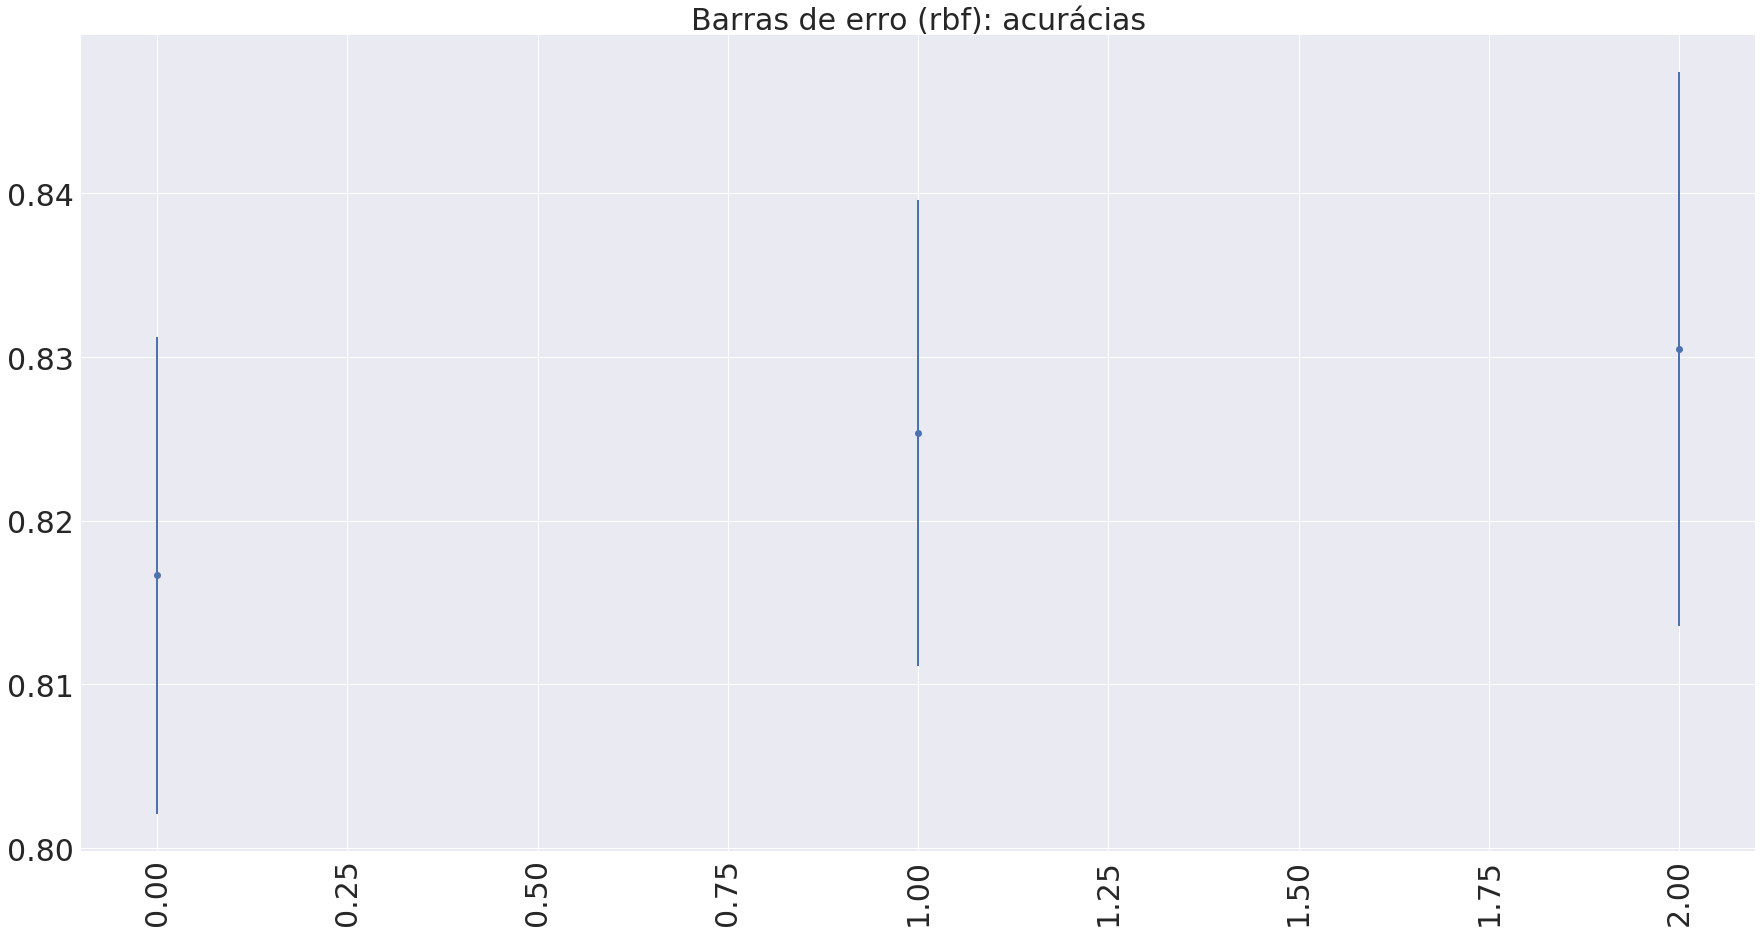

,0,1,2
split0_test_f1,0.830325,0.836096,0.842301
split1_test_f1,0.844278,0.841121,0.845283
split2_test_f1,0.814259,0.807407,0.8125
split3_test_f1,0.834559,0.845588,0.845173
split4_test_f1,0.810909,0.83054,0.833021
split5_test_f1,0.80597,0.820702,0.815238
split6_test_f1,0.833021,0.837121,0.8577
split7_test_f1,0.828996,0.839319,0.834615
split8_test_f1,0.833652,0.845124,0.844961
split9_test_f1,0.835249,0.845283,0.847784


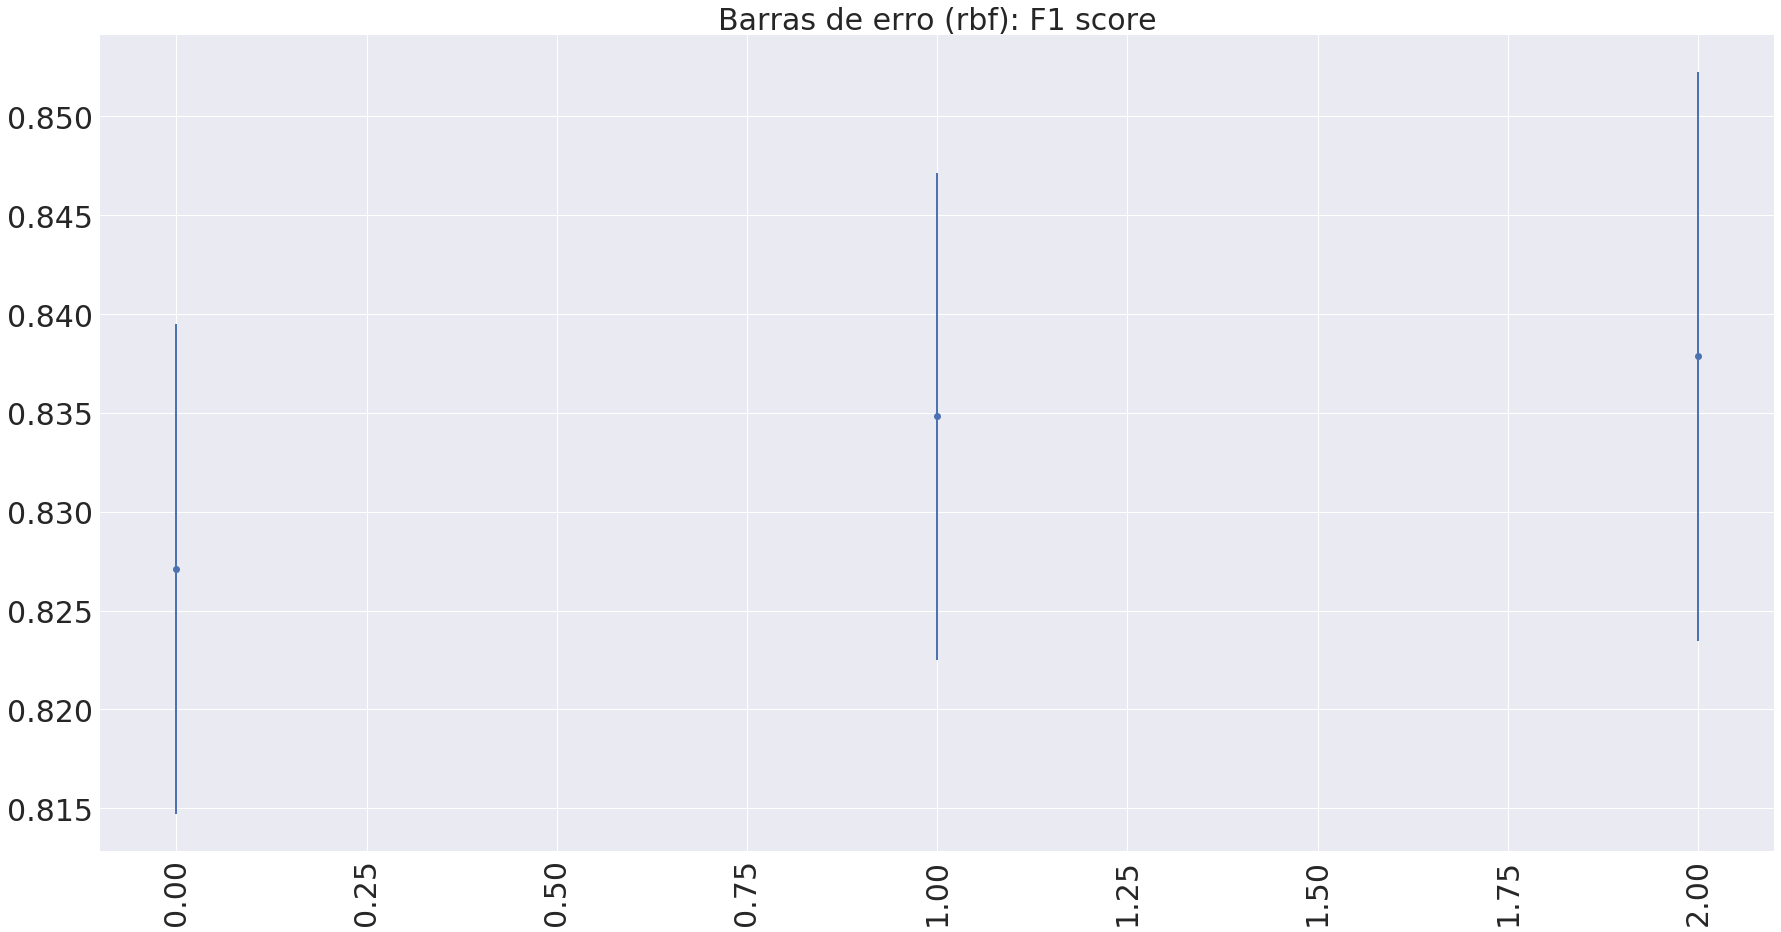

,0,1,2
split0_test_precision,0.766667,0.785467,0.796491
split1_test_precision,0.803571,0.797872,0.808664
split2_test_precision,0.775,0.759582,0.75945
split3_test_precision,0.780069,0.790378,0.783784
split4_test_precision,0.750842,0.785211,0.792857
split5_test_precision,0.763251,0.770833,0.786765
split6_test_precision,0.792857,0.803636,0.846154
split7_test_precision,0.782456,0.804348,0.812734
split8_test_precision,0.807407,0.818519,0.828897
split9_test_precision,0.810409,0.808664,0.827068


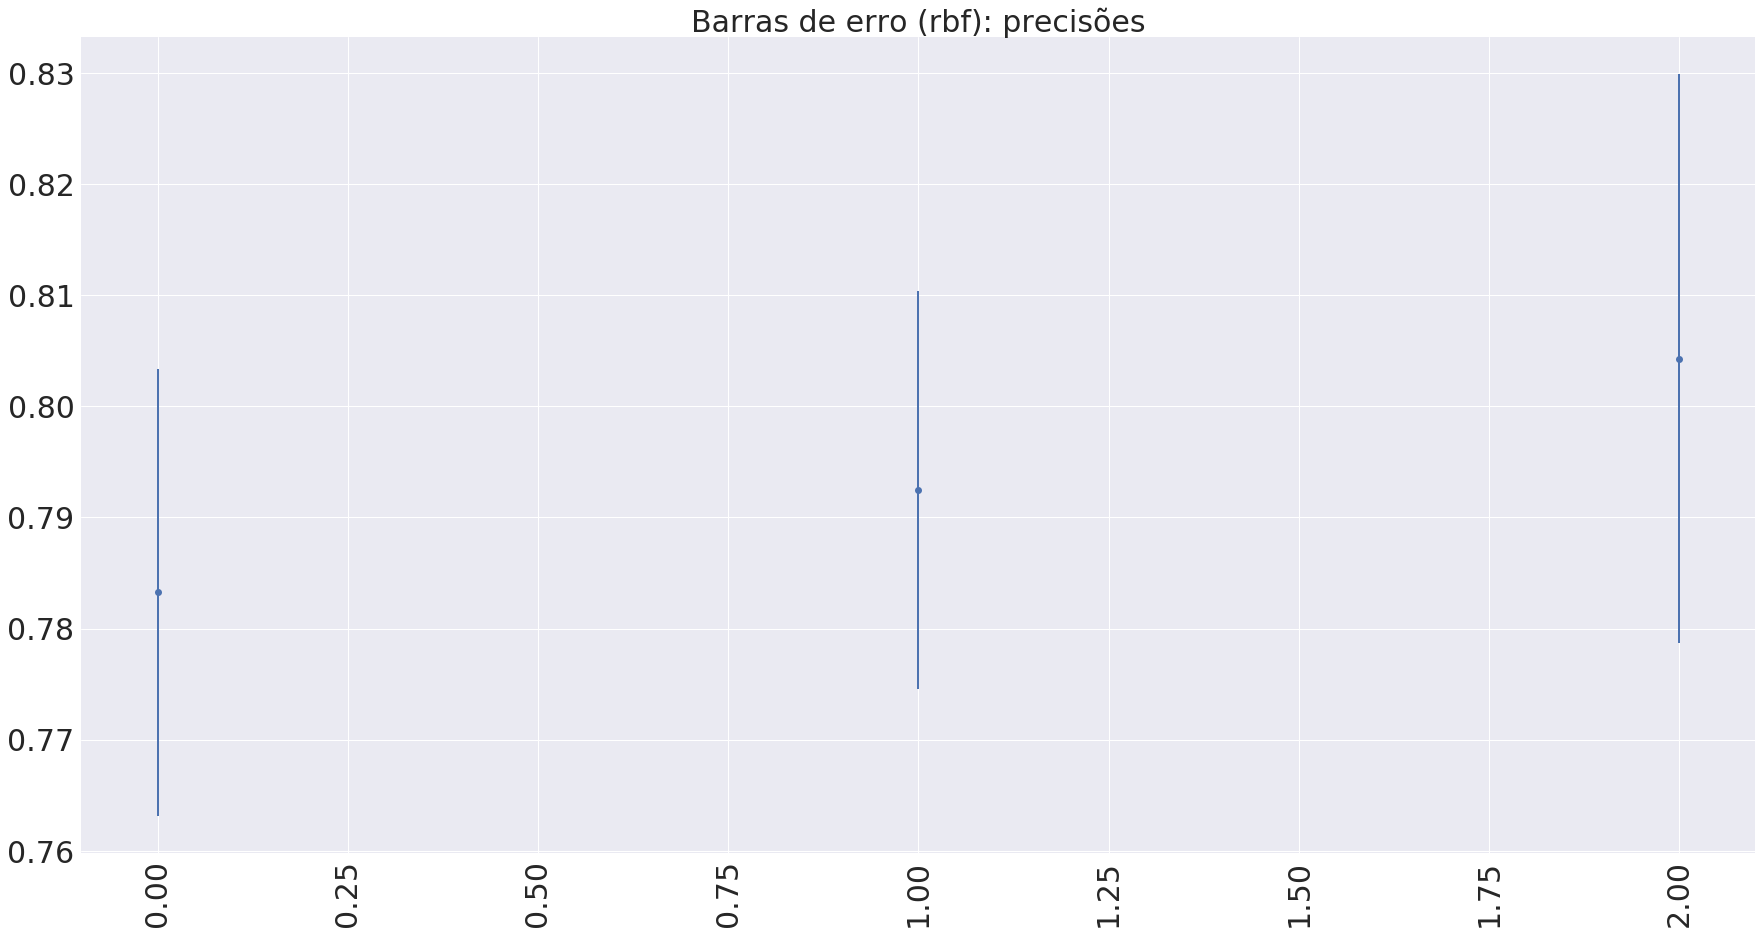

,0,1,2
split0_test_recall,0.905512,0.893701,0.893701
split1_test_recall,0.889328,0.889328,0.885375
split2_test_recall,0.857708,0.86166,0.873518
split3_test_recall,0.897233,0.909091,0.916996
split4_test_recall,0.881423,0.881423,0.87747
split5_test_recall,0.853755,0.87747,0.84585
split6_test_recall,0.87747,0.873518,0.869565
split7_test_recall,0.881423,0.87747,0.857708
split8_test_recall,0.86166,0.873518,0.86166
split9_test_recall,0.86166,0.885375,0.869565


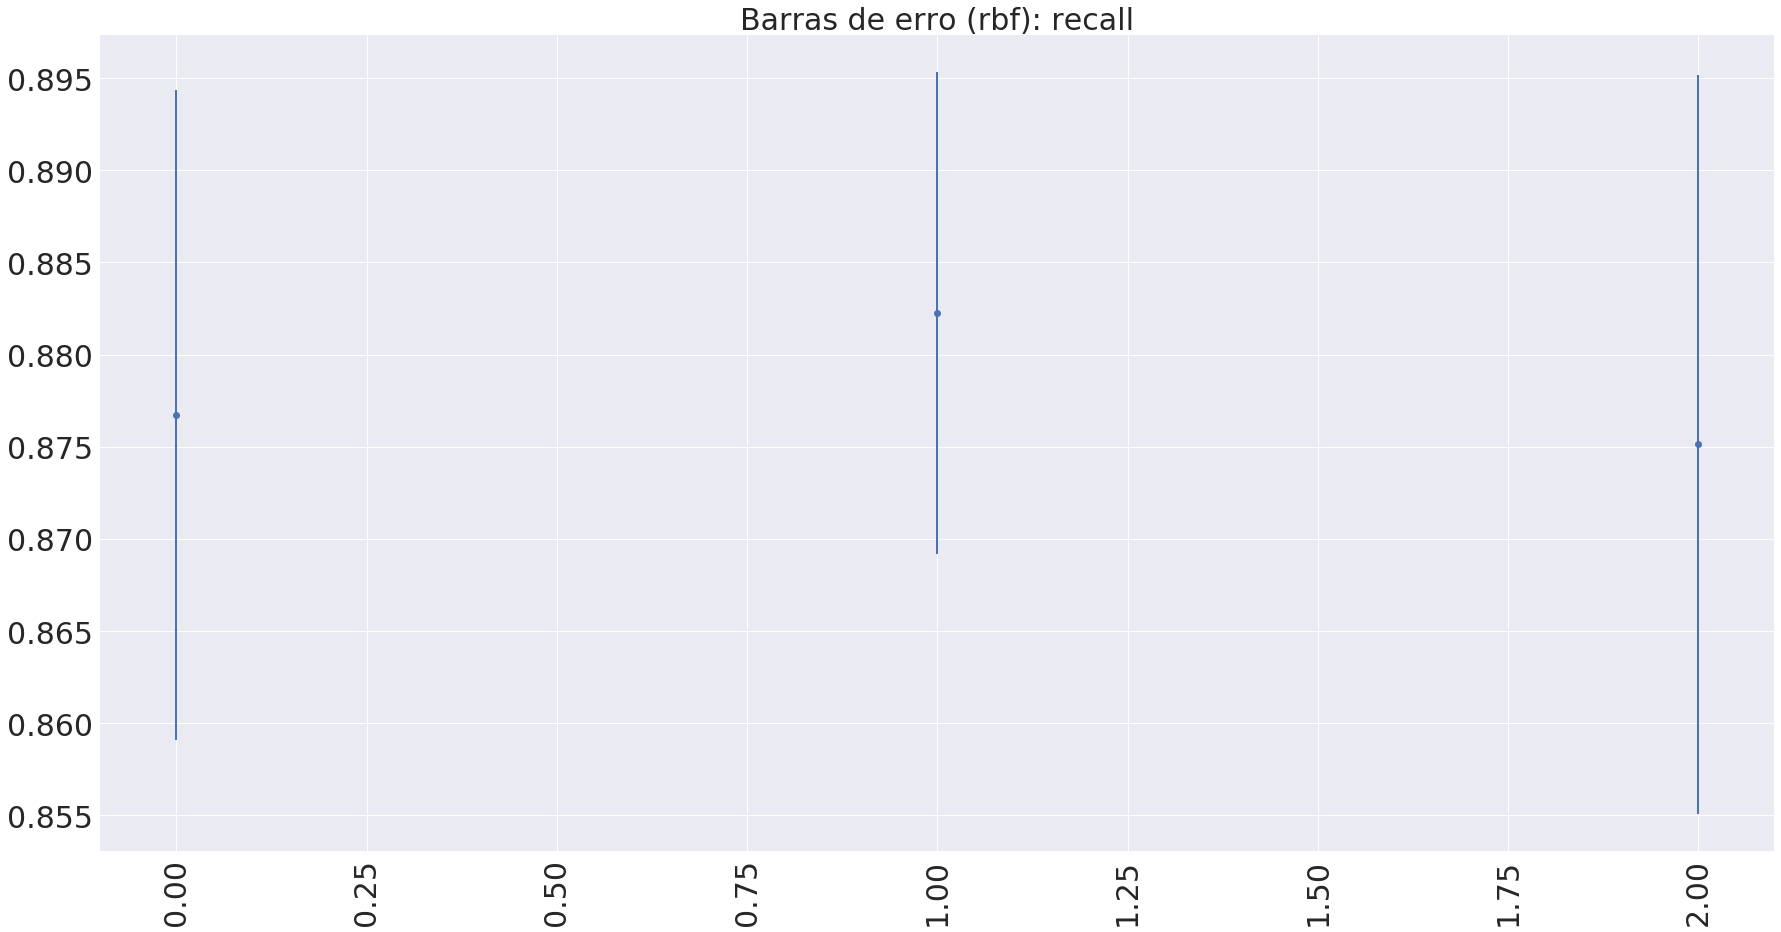

,0,1,2
split0_test_roc_auc,0.893546,0.892926,0.896661
split1_test_roc_auc,0.901483,0.904263,0.905045
split2_test_roc_auc,0.876486,0.882485,0.885844
split3_test_roc_auc,0.896827,0.902654,0.906685
split4_test_roc_auc,0.894405,0.904482,0.90681
split5_test_roc_auc,0.880501,0.898639,0.897093
split6_test_roc_auc,0.913247,0.917387,0.918605
split7_test_roc_auc,0.906435,0.919543,0.920714
split8_test_roc_auc,0.913059,0.923761,0.927635
split9_test_roc_auc,0.910466,0.920324,0.924339


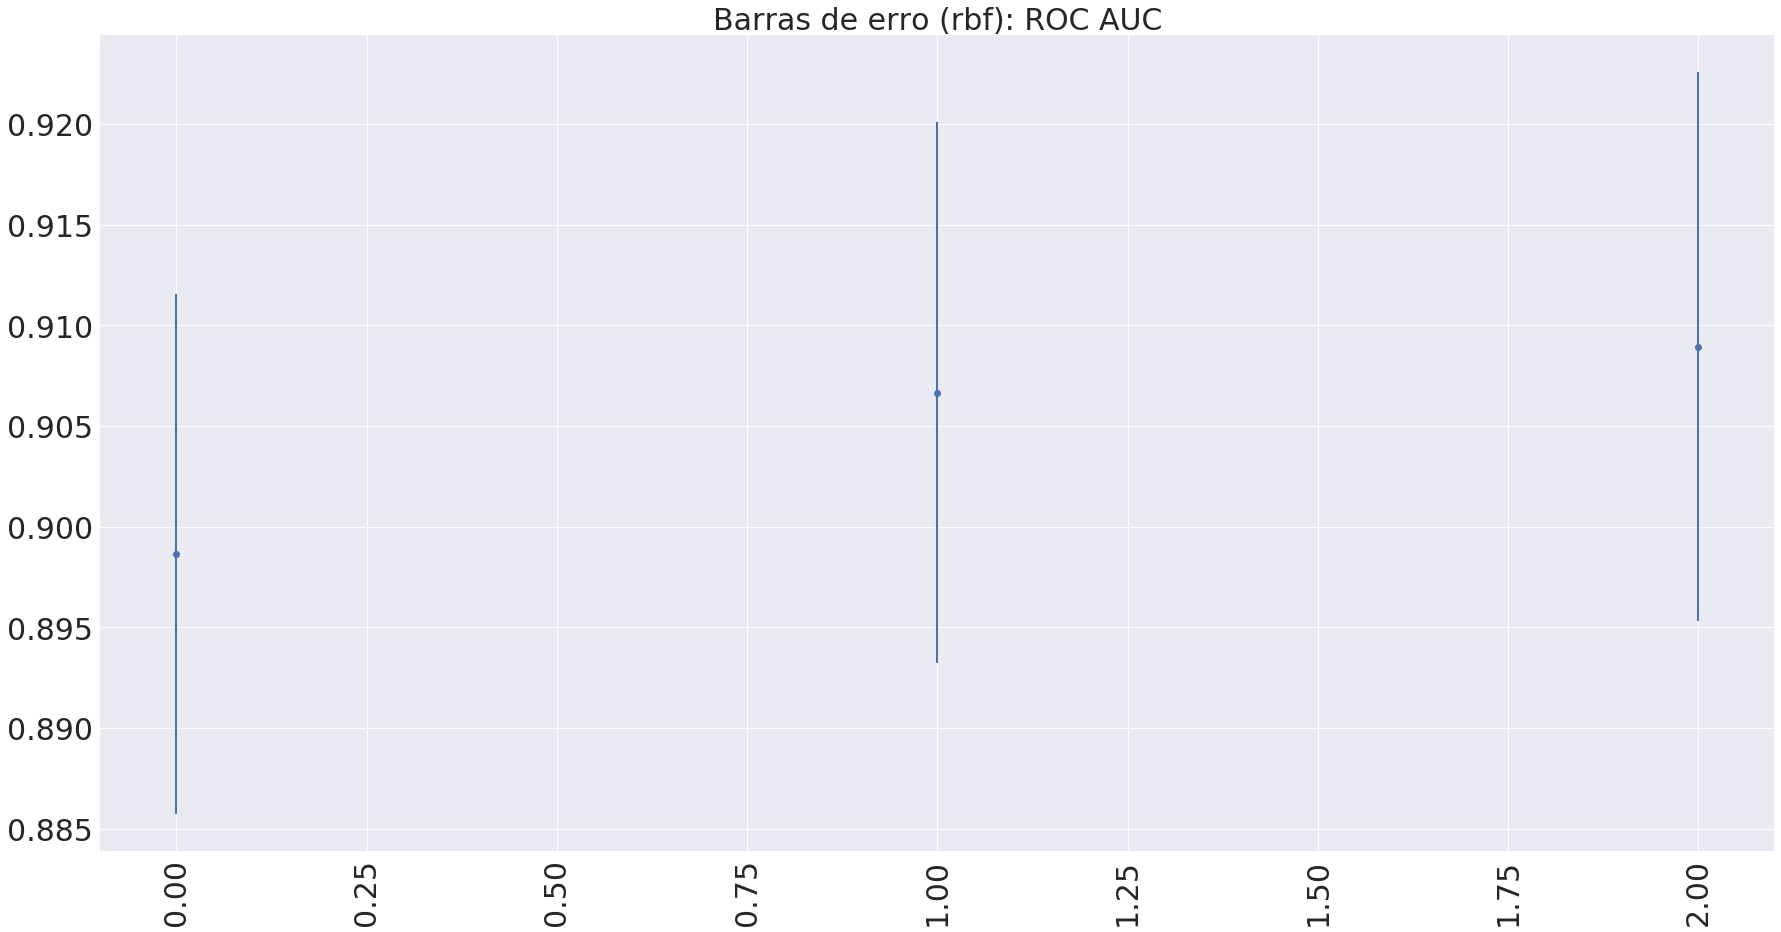

In [23]:
variable_param = 'param_n_neuronios'
variable_param_num_values = 12 
variable_param_exp_start_value = 1 
variable_param_exp_end_value = 12
variable_param_base = 2
variable_param_values = np.logspace(start=variable_param_exp_start_value,stop=variable_param_exp_end_value,
                                    num=variable_param_num_values,base=variable_param_base)

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_' + str(metrica[0])).transpose()
    results_train_filtered = results_train.filter(regex='.*_train_' + str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))
    plt.semilogx(variable_param_values, results_test_filtered.mean(), 
                 label='Validação', color='green', lw=2, basex=variable_param_base)

    plt.fill_between(variable_param_values, results_test_filtered.mean() - results_test_filtered.std(),
                 results_test_filtered.mean() + results_test_filtered.std(), alpha=0.2, color='green', lw=2)

    plt.semilogx(variable_param_values, results_train_filtered.mean(), 
                 label='Treino', color='blue', lw=2, basex=variable_param_base)

    plt.fill_between(variable_param_values, results_train_filtered.mean() - results_train_filtered.std(),
                 results_train_filtered.mean() + results_train_filtered.std(), alpha=0.2, color='blue', lw=2)

    plot_title = 'Curvas de validação: ' + metrica[1]
    plot_xlabel = 'Número de neurônios'

    plt.title(plot_title, fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.xlabel(plot_xlabel, fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc='best', fontsize=30)

#         filename_graficos = 'svm-rbf-abordagem-2-'+str_balanceamento+'-curvas_validacao-'+variable_param+'-'+str(metrica[0])+'.png'
#         plt.savefig(path_graficos+filename_graficos)

    plt.show()

In [ ]:
path_arquivos = 'Classificadores/Redes-neurais-MLP-2/'
path_graficos = 'Classificadores/Redes-neurais-MLP-2/graficos/'
str_balanceamento='balanceado'
param = 'param_n_neuronios'

results = joblib.load(path_arquivos+'mlp-one-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')
# display(results)
results.sort_values(by=[param], axis=0, inplace=True)

results_test = results.loc[:, 'split0_train_accuracy':'split9_test_roc_auc']
display(results_test)
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()
    
    display(results_test_filtered)

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(np.arange(0,len(results_test_filtered.columns)), results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    
#     filename_graficos = 'svm-rbf-abordagem-2-'+str_balanceamento+'-erros-'+str(metrica[0])+'.png'
#     plt.savefig(path_graficos+filename_graficos)
    
    plt.show()

In [ ]:
variable_param = 'param_n_neuronios'
variable_param_num_values = 12 
variable_param_exp_start_value = 1 
variable_param_exp_end_value = 12
variable_param_base = 2
variable_param_values = np.logspace(start=variable_param_exp_start_value,stop=variable_param_exp_end_value,
                                    num=variable_param_num_values,base=variable_param_base)

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_' + str(metrica[0])).transpose()
    results_train_filtered = results_train.filter(regex='.*_train_' + str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))
    plt.semilogx(variable_param_values, results_test_filtered.mean(), 
                 label='Validação', color='green', lw=2, basex=variable_param_base)

    plt.fill_between(variable_param_values, results_test_filtered.mean() - results_test_filtered.std(),
                 results_test_filtered.mean() + results_test_filtered.std(), alpha=0.2, color='green', lw=2)

    plt.semilogx(variable_param_values, results_train_filtered.mean(), 
                 label='Treino', color='blue', lw=2, basex=variable_param_base)

    plt.fill_between(variable_param_values, results_train_filtered.mean() - results_train_filtered.std(),
                 results_train_filtered.mean() + results_train_filtered.std(), alpha=0.2, color='blue', lw=2)

    plot_title = 'Curvas de validação: ' + metrica[1]
    plot_xlabel = 'Número de neurônios'

    plt.title(plot_title, fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.xlabel(plot_xlabel, fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc='best', fontsize=30)

#         filename_graficos = 'svm-rbf-abordagem-2-'+str_balanceamento+'-curvas_validacao-'+variable_param+'-'+str(metrica[0])+'.png'
#         plt.savefig(path_graficos+filename_graficos)

    plt.show()

In [25]:
# def gerarLinhaTabelaResultadosCVRedeNeural(metricas, 
#                                            n_splits,
#                                            train_scores_acc, 
#                                            train_scores_f1,
#                                            train_scores_roc,
#                                            val_scores_acc,
#                                            val_scores_f1,
#                                            val_scores_roc):

#     # Tabela com resultados de treino

#     tb_train = pd.DataFrame(columns=['split'+str(i)+'_train_'+metrica for i in list(range(0,n_splits)) for metrica in metricas])

#     idx_vetores = -1
#     for idx2,col in enumerate(tb_train.columns):
#         if idx2%3 == 0:
#             idx_vetores += 1
#             vetor = train_scores_acc
#         elif idx2%3 == 1:
#             vetor = train_scores_f1
#         elif idx2%3 == 2:
#             vetor = train_scores_roc

#         tb_train.loc[0,col] = vetor[idx_vetores]
        
# #     display(tb_train)

#     # Tabela com resultados de validação

#     tb_val = pd.DataFrame(columns=['split'+str(i)+'_test_'+metrica for i in list(range(0,n_splits)) for metrica in metricas])

#     idx_vetores = -1
#     for idx2,col in enumerate(tb_val.columns):
#         if idx2%3 == 0:
#             idx_vetores += 1
#             vetor = val_scores_acc
#         elif idx2%3 == 1:
#             vetor = val_scores_f1
#         elif idx2%3 == 2:
#             vetor = val_scores_roc

#         tb_val.loc[0,col] = vetor[idx_vetores]

#     # Concatenação das duas tabelas

#     tb = pd.concat([tb_train, tb_val], axis=1)

# #     # Adicionando as colunas com os parâmetros

# #     tb['param_n_neuronios'] = param_range
    
#     return tb, tb.values

# temp, linha = gerarLinhaTabelaResultadosCVRedeNeural(metricas, 
#                                                        n_splits_kfold,
#                                                        train_scores_acc,
#                                                        train_scores_f1,
#                                                        train_scores_roc,
#                                                        val_scores_acc,
#                                                        val_scores_f1,
#                                                        val_scores_roc)
